In [1]:
%reload_ext autoreload

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from quantum_tools.examples import symbolic_contexts
from quantum_tools.symmetries.workspace import get_contraction_elements
from quantum_tools.examples.prob_dists import *
from quantum_tools.utilities.job_queuer_async import JobContext
from quantum_tools.utilities.constants import *
from quantum_tools.config import *
from quantum_tools.visualization.hypergraph import *
from quantum_tools.visualization.transversal_inequalities import *
from quantum_tools.visualization.triangle_plot import *
from quantum_tools.hypergraph.hypergraph_transversals import *
from quantum_tools.hypergraph.inequalities import *
from quantum_tools.contexts.measurement import *
from quantum_tools.contexts.quantum_caller import *
# from quantum_tools.inflation.positive_linear_solve import *
from quantum_tools.contexts.state import *
from quantum_tools.contexts.quantum_context import *
from scipy import sparse, optimize
import numpy as np
from quantum_tools.rmt import rmt
import math
from scipy import io
from cmath import exp
import os
from itertools import product, combinations, permutations, combinations_with_replacement
from functools import reduce
from operator import mul, itemgetter

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = False

## Initial Config

In [11]:
deflated_rvc = RandomVariableCollection.new(('A', 'B', 'C'), (4, 4, 4))

dimensions = 2
triangle_permutation = utils.get_triangle_permutation(dimensions)

## Modifications to Fritz

<IPython.core.display.Javascript object>


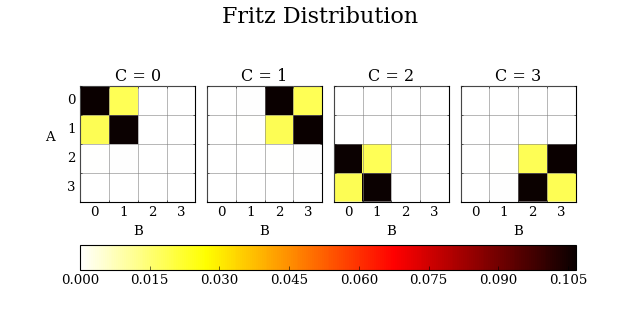

In [214]:
triangle_plot_2(fritz(deflated_rvc), title='Fritz Distribution', save=utils.temp_dir('fritz_dist_plotted.pdf'))

<IPython.core.display.Javascript object>


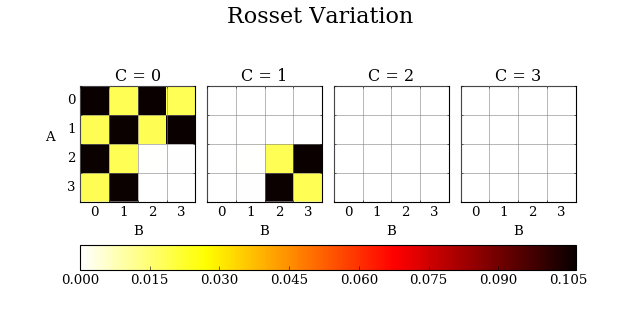

In [220]:
# Modifying Fritz Distribution to have Charlie output Ain * Bin instead of {Ain, Bin}
# anti_correlated_index (index that is treated as being anticorrelated)
def modify_charlie(normal_fritz_dist, anti_correlated_index = 3):
    normal_support = normal_fritz_dist._support
    support = np.zeros(normal_support.shape)
    support[:,:,0] = sum([normal_support[:,:,i] for i in range(support.shape[2])]) \
                          - normal_support[:,:,anti_correlated_index]
    support[:,:,1] = normal_support[:,:,anti_correlated_index]
    
    return ProbDist(deflated_rvc, support)
    
    
triangle_plot_2(modify_charlie(fritz(deflated_rvc)), title='Rosset Variation', save=utils.temp_dir('rosset_variation_plotted.pdf'))

## Symbolic Contexts For Different Inflations

In [37]:
# Wagon Wheel Inflation
wagon_wheel_symbolic_context = SymbolicContext(
    preinjectable_sets=[
        [['A2', 'B1', 'C3'], ['C1']],
        [['A1', 'B1', 'C4'], ['C2']],
        [['A1', 'B2', 'C1'], ['C3']],
        [['A2', 'B2', 'C2'], ['C4']],
    ],
    outcomes=[4,4,4,4,4,4,4,4,]
)

wagon_wheel_infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(wagon_wheel_symbolic_context.preinjectable_sets),
    outcomes=wagon_wheel_symbolic_context.outcomes
)
wagon_wheel_b_string = get_preinjectablesets_latex(wagon_wheel_infl_rvc, wagon_wheel_symbolic_context.preinjectable_sets)
wagon_wheel_duplication_map = get_duplication_map(wagon_wheel_b_string)

In [38]:
# Web Inflation
web_symbolic_context = SymbolicContext(
    preinjectable_sets=[
        [['A1', 'B1', 'C1'], ['A4', 'B4', 'C4']],
        [['A1', 'B2', 'C3'], ['A4', 'B3', 'C2']],
        [['A2', 'B3', 'C1'], ['A3', 'B2', 'C4']],
        [['A2', 'B4', 'C3'], ['A3', 'B1', 'C2']],
        [['A1'], ['B3'], ['C4']],
        [['A1'], ['B4'], ['C2']],
        [['A2'], ['B1'], ['C4']],
        [['A2'], ['B2'], ['C2']],
        [['A3'], ['B3'], ['C3']],
        [['A3'], ['B4'], ['C1']],
        [['A4'], ['B1'], ['C3']],
        [['A4'], ['B2'], ['C1']],
    ],
    outcomes=[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,]
)

web_infl_rvc = RandomVariableCollection.new(
    names=marginal_equality.rv_names_from_sc(web_symbolic_context.preinjectable_sets),
    outcomes=web_symbolic_context.outcomes
)
web_b_string = get_preinjectablesets_latex(web_infl_rvc, web_symbolic_context.preinjectable_sets)
web_duplication_map = get_duplication_map(web_b_string)

## Computing Inequalities

In [51]:
wagon_wheel_incidence = marginal_equality.marginal_mtrx(wagon_wheel_infl_rvc, wagon_wheel_symbolic_context.preinjectable_sets)
wagon_wheel_incidence = wagon_wheel_incidence.astype('int16') # Comes out as bool
wagon_wheel_incidence_format_cache = construct_format_cache(wagon_wheel_incidence)

In [217]:
wagon_wheel_incidence.shape

(1024, 65536)

#### DEPT

In [206]:
dept_objs = []

def dept(target_dist, symbolic_contexts, antecedents):
    target_b = get_b(target_dist, symbolic_contexts)
    positive_antecedents = np.where(target_b >= 1e-6)[0]
    print(positive_antecedents)
    
    return_objs = []
    
    for ant in antecedents:
        if ant not in positive_antecedents:
            continue
        ret_obj = weighted_transversal(wagon_wheel_incidence_format_cache, target_b, ant)
        return_objs.append(ret_obj)
    
    return return_objs

In [212]:
dept_objs.append(dept(fritz(deflated_rvc), wagon_wheel_symbolic_context.preinjectable_sets, range(1024)))

[   0    4    8   12   16   20   24   28   33   37   41   45   49   53   57   61   64   68   72   76   80   84   88   92
   97  101  105  109  113  117  121  125  130  134  138  142  146  150  154  158  163  167  171  175  179  183  187  191
  194  198  202  206  210  214  218  222  227  231  235  239  243  247  251  255  256  260  264  268  272  276  280  284
  289  293  297  301  305  309  313  317  320  324  328  332  336  340  344  348  353  357  361  365  369  373  377  381
  386  390  394  398  402  406  410  414  419  423  427  431  435  439  443  447  450  454  458  462  466  470  474  478
  483  487  491  495  499  503  507  511  512  513  514  515  528  529  530  531  548  549  550  551  564  565  566  567
  576  577  578  579  592  593  594  595  612  613  614  615  628  629  630  631  648  649  650  651  664  665  666  667
  684  685  686  687  700  701  702  703  712  713  714  715  728  729  730  731  748  749  750  751  764  765  766  767
  768  769  770  771  784  785  

In [211]:
dept_objs

[[{'antecedent': 0}, {'antecedent': 4}, {'antecedent': 16}],
 [{'antecedent': 0}, {'antecedent': 4}],
 [{'antecedent': 0},
  {'antecedent': 4},
  {'antecedent': 16},
  {'antecedent': 20},
  {'antecedent': 32},
  {'antecedent': 36},
  {'antecedent': 48},
  {'antecedent': 52},
  {'antecedent': 64},
  {'antecedent': 68},
  {'antecedent': 80},
  {'antecedent': 84},
  {'antecedent': 96}],
 [{'antecedent': 0},
  {'antecedent': 4},
  {'antecedent': 16},
  {'antecedent': 20},
  {'antecedent': 32},
  {'antecedent': 36},
  {'antecedent': 48},
  {'antecedent': 52},
  {'antecedent': 64},
  {'antecedent': 68},
  {'antecedent': 80},
  {'antecedent': 84},
  {'antecedent': 96},
  {'antecedent': 100},
  {'antecedent': 112},
  {'antecedent': 116},
  {'antecedent': 128},
  {'antecedent': 132},
  {'antecedent': 144},
  {'antecedent': 148},
  {'antecedent': 161},
  {'antecedent': 165},
  {'antecedent': 177},
  {'antecedent': 181},
  {'antecedent': 192},
  {'antecedent': 196},
  {'antecedent': 208},
  {'ant

In [141]:
post_process_fts_object(dept_objs[-1][0])

In [117]:
Latex(*output_to_ineq(dept_objs[-1][0], wagon_wheel_b_string))

## Saving Inequalities

In [152]:
def save_ineq_with_name(name, obj):
    post_process_fts_object(obj)
    np.savetxt(utils.temp_dir(name), obj['w'])

In [153]:
save_ineq_with_name('wagon_wheel_fritz_12.csv', dept(fritz(deflated_rvc), wagon_wheel_symbolic_context.preinjectable_sets, [12])[0])

[   0    4    8   12   16   20   24   28   33   37   41   45   49   53   57   61   64   68   72   76   80   84   88   92
   97  101  105  109  113  117  121  125  130  134  138  142  146  150  154  158  163  167  171  175  179  183  187  191
  194  198  202  206  210  214  218  222  227  231  235  239  243  247  251  255  256  260  264  268  272  276  280  284
  289  293  297  301  305  309  313  317  320  324  328  332  336  340  344  348  353  357  361  365  369  373  377  381
  386  390  394  398  402  406  410  414  419  423  427  431  435  439  443  447  450  454  458  462  466  470  474  478
  483  487  491  495  499  503  507  511  512  513  514  515  528  529  530  531  548  549  550  551  564  565  566  567
  576  577  578  579  592  593  594  595  612  613  614  615  628  629  630  631  648  649  650  651  664  665  666  667
  684  685  686  687  700  701  702  703  712  713  714  715  728  729  730  731  748  749  750  751  764  765  766  767
  768  769  770  771  784  785  

## Trying To Compactify Inequality

In [201]:
def compactify_inequality(b_string, w):
    return (latex_inequality(w[:, i].flatten(), b_string) for i in range(w.shape[1]))

list(compactify_inequality(wagon_wheel_b_string, dept_objs[-1][0]['w_full']))

['P_{ABC}(000)P_{C}(3) \\leq 2P_{ABC}(001)P_{C}(0) + 2P_{ABC}(001)P_{C}(1) + 2P_{ABC}(001)P_{C}(2) + 2P_{ABC}(001)P_{C}(3) + 2P_{ABC}(002)P_{C}(0) + 2P_{ABC}(002)P_{C}(1) + 2P_{ABC}(002)P_{C}(2) + 2P_{ABC}(002)P_{C}(3) + 2P_{ABC}(003)P_{C}(1) + 2P_{ABC}(003)P_{C}(2) + 2P_{ABC}(003)P_{C}(3) + 2P_{ABC}(013)P_{C}(0) + 2P_{ABC}(023)P_{C}(0) + 2P_{ABC}(033)P_{C}(0) + 2P_{ABC}(103)P_{C}(0) + 2P_{ABC}(203)P_{C}(0) + 2P_{ABC}(303)P_{C}(0) + 3P_{ABC}(003)P_{C}(0) + P_{ABC}(011)P_{C}(0) + P_{ABC}(011)P_{C}(1) + P_{ABC}(011)P_{C}(2) + P_{ABC}(011)P_{C}(3) + P_{ABC}(012)P_{C}(0) + P_{ABC}(012)P_{C}(1) + P_{ABC}(012)P_{C}(2) + P_{ABC}(012)P_{C}(3) + P_{ABC}(013)P_{C}(1) + P_{ABC}(013)P_{C}(2) + P_{ABC}(013)P_{C}(3) + P_{ABC}(020)P_{C}(0) + P_{ABC}(020)P_{C}(1) + P_{ABC}(020)P_{C}(2) + P_{ABC}(020)P_{C}(3) + P_{ABC}(022)P_{C}(0) + P_{ABC}(022)P_{C}(1) + P_{ABC}(022)P_{C}(2) + P_{ABC}(022)P_{C}(3) + P_{ABC}(023)P_{C}(1) + P_{ABC}(023)P_{C}(2) + P_{ABC}(023)P_{C}(3) + P_{ABC}(030)P_{C}(0) + P_{ABC}(03

### Visualizing the Hypergraph Transversal

In [108]:
def visualize_greedy_seed(antecedent, incidence_format_cache, b_string, target_b):
    print(b_string[antecedent])
    hg_rows, hg, hg_cols = hyper_graph(incidence_format_cache, antecedent, remove=get_removal(target_b,antecedent))
    plt_small_hg(hg)
    hg_rows, hg, hg_cols = sort_hg(hg_rows, hg, hg_cols, nodes_desc=target_b)
    plt_small_hg(hg)
    starting_transversal = sparse.csc_matrix((target_b[hg_rows] == 0).astype(int)[:, np.newaxis])

    super_reduced = perform_starting_transversal_reduction(hg, starting_transversal)
    unused_nonempty_H, used_nodes, unused_nodes, unused_empty_nodes, unused_nonempty_nodes = super_reduced

    plt_small_hg(unused_nonempty_H)
    
    antecedent_weight = target_b[antecedent]
    node_weights= target_b[hg_rows][unused_nodes][unused_nonempty_nodes]

In [106]:
def plt_small_hg(hg):
    if hg.nnz > 0:
        plt.matshow(hg.todense(), cmap='hot_r')    

P_{ABC}(000)P_{C}(3)


<IPython.core.display.Javascript object>


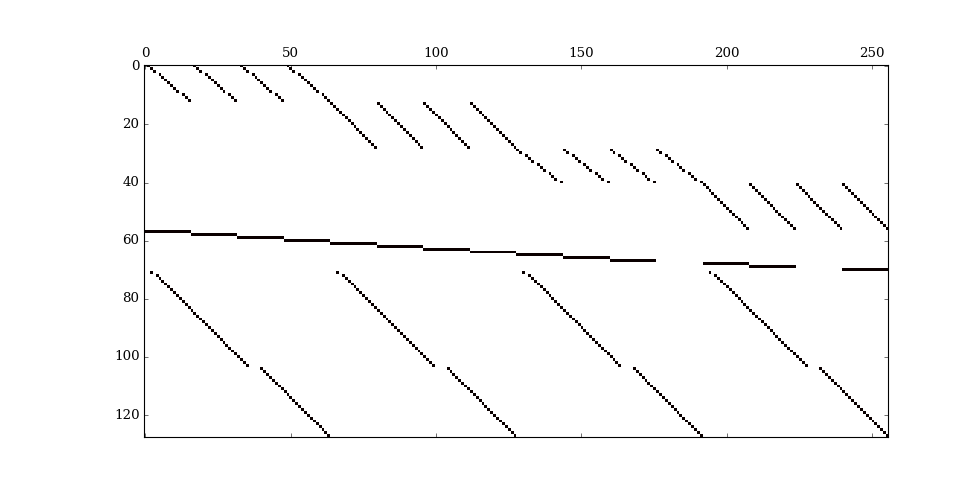

<IPython.core.display.Javascript object>


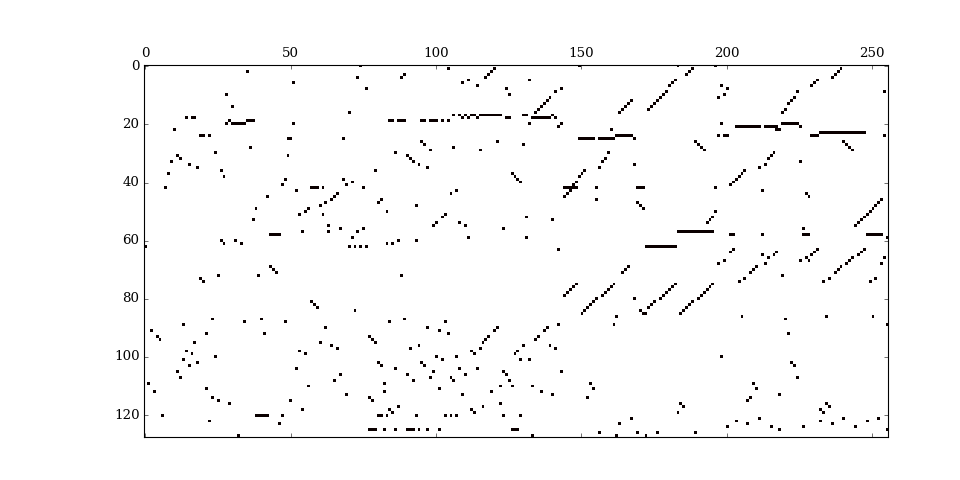

108 used nodes
20 unused nodes
16 unused empty nodes
4 unused non-empty nodes
Hypergraph reduced from (128, 256) to (4, 4)


<IPython.core.display.Javascript object>


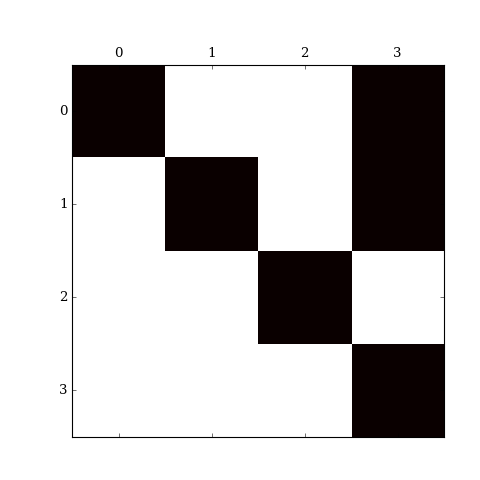

In [109]:
visualize_greedy_seed(
    12,
    wagon_wheel_incidence_format_cache,
    wagon_wheel_b_string,
    get_b(fritz(deflated_rvc), wagon_wheel_symbolic_context.preinjectable_sets)
)

## Optimizing

#### Fritz Param
Computing the Fritz Parameters and then saving them

In [166]:
active_qc = QuantumCaller(pd_matching(fritz(deflated_rvc)),deflated_rvc,triangle_permutation)
res = optimize.minimize(active_qc, np.random.uniform(0, 2*np.pi, active_qc.size), tol=0.001, callback=minimize_callback(active_qc))

0.29236160550694085
0.2863783407914641
0.2791859502178637
0.27758894428667064
0.2746328382546983
0.2695364364602071
0.26890847977321014
0.26453326506569186
0.2613192143929116
0.25555916024027014
0.24868584662377052
0.23212600130608585
0.22224194057815566
0.20452465646261717
0.18560470313022956
0.16697874255332454
0.1431960417938065
0.10868685187473036
0.08960538311713927
0.0631660606098313
0.05787326780929047
0.04806253398711382
0.03124596185831364
0.022971053582869248
0.01990889377305118
0.018133047119344794
0.015140716862482806
0.011068258961770784
0.009280026434186505
0.008500369093388478
0.0073460199438982595
0.005622986891955633
0.004899980110284887
0.004061218433829445
0.0030561562697954824
0.0028004006831496677
0.002422886604126236
0.001937991790632572
0.0017375175504820027
0.0014361916269448334
0.0012124430059365795
0.0010421167644923432
0.0008445686131279701
0.000716800647877877
0.0005996881758109599
0.00043253541808142246
0.0003427408883461798
0.0002954033405655575
0.00024588

In [167]:
np.savetxt(utils.temp_dir('fritz_quantum_caller_param.csv'), res.x)

#### Loading Inequalities

In [168]:
wagon_wheel_fritz_12 = np.loadtxt(utils.temp_dir('wagon_wheel_fritz_12.csv'))
fritz_quantum_caller_param = np.loadtxt(utils.temp_dir('fritz_quantum_caller_param.csv'))

#### Running Optimization Scripts

In [218]:
active_qc = QuantumCaller(w_to_target(wagon_wheel_fritz_12,wagon_wheel_symbolic_context.preinjectable_sets),deflated_rvc,triangle_permutation)
x0 = stochastic_jump(fritz_quantum_caller_param, 0.01)
# x0 = np.random.uniform(0, 2*np.pi, active_qc.size)
res = optimize.minimize(active_qc, x0, tol=0.0001, method=None, callback=minimize_callback(active_qc))

-0.00667188323978
-0.0104389031943
-0.0113779921702
-0.0122316490792
-0.0124639825485
-0.012713387323
-0.012783923276
-0.012843621642
-0.0128721534068
-0.012893089262
-0.0129059135661
-0.0129164142602
-0.0129239456531
-0.0129299745862
-0.0129341210749
-0.012936417864
-0.012937623953
-0.0129385291479
-0.0129393759083
-0.0129401678162
-0.0129409119628
-0.0129416060211
-0.0129421653255
-0.0129425328246
-0.0129427790665
-0.0129429894473
-0.0129431791126
-0.012943330961
-0.0129434549785
-0.0129435742755
-0.0129436861697
-0.0129437678359


In [219]:
print(active_qc(res.x))
print(active_qc(fritz_quantum_caller_param))

-0.0129437678359
-0.0129428304698


<IPython.core.display.Javascript object>


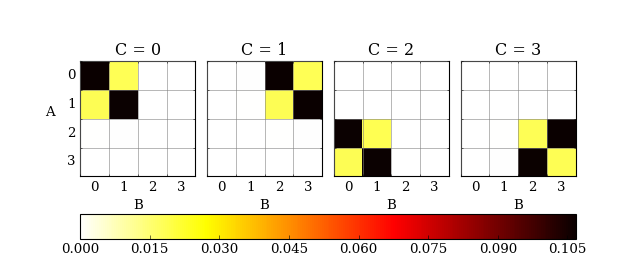

In [191]:
triangle_plot_2(active_qc.context(res.x))

## Noise

<IPython.core.display.Javascript object>


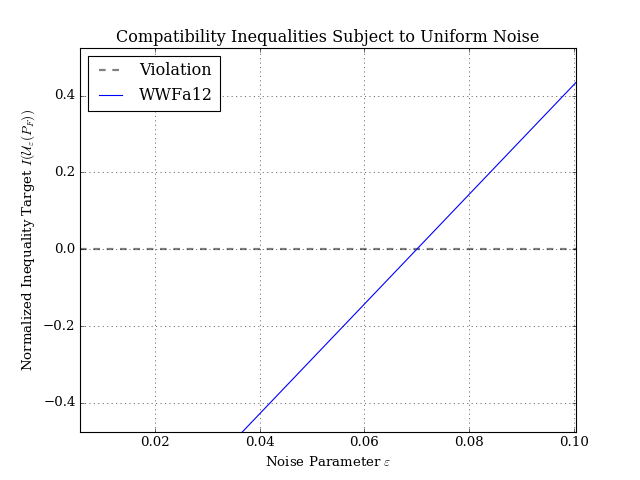

In [230]:
plot_noise([w_to_target(np.loadtxt(utils.temp_dir('wagon_wheel_fritz_12.csv')), wagon_wheel_symbolic_context.preinjectable_sets)], ['WWFa12'], utils.temp_dir('wagon_wheel_12.pdf'))

# Utilities

In [79]:
def ifi(fts):
    for i in range(fts.shape[1]):
        yield fts.indices[fts.indptr[i]:fts.indptr[i+1]]

In [50]:
def construct_format_cache(incidence):
    incidence_format_cache = { # Best for accessing the incidence in numerous ways
        'csc': sparse.csc_matrix(incidence),
        'csr': sparse.csr_matrix(incidence),
    }
    return incidence_format_cache

## Weighted Transversals

In [54]:
def get_aprint(antecedent):
    def _aprint(*args):
        msg = '{:<5} :: '.format(antecedent) + ' '.join(args) + os.linesep
        sys.stdout.write(msg)
        sys.stdout.flush()
    return _aprint

In [60]:
def get_removal(target_b, antecedent):
#     duplicate_antecedents = duplication_map[b_string[antecedent]]
    remove_list = []
    larger_positive_consequents = np.where(target_b >= target_b[antecedent])[0]
    remove_list.append(larger_positive_consequents)
        
    remove_stack = np.hstack(remove_list)
    return remove_stack

In [69]:
def filter_against_target(b, antecedent, hg_rows):
    
    antecedent_value = b[antecedent] # The lhs of the inequality
    marginals_hg_space = b[hg_rows] # The marginals in the space of the hypergraph (values on nodes)
    
    def target_filter(wt_indices):
        """
        wt: The working transversal to consider filtering out
        """
        consequent_values = marginals_hg_space[wt_indices] # The values of the particular consequents
        target = np.sum(consequent_values, axis=0) - antecedent_value # This value *should* be positive if no hardy paradox
#         print(target)
        return target > -1e-6

    return target_filter

In [75]:
def weighted_transversal(incidence_format_cache, target_b, antecedent, find_up_to=1):
    aprint = get_aprint(antecedent)
    aprint('Antecedent: {}'.format(antecedent))
    ret_obj = {'antecedent': antecedent}
    remove = get_removal(target_b, antecedent)
    aprint('Number of nodes removed (including ant) {}'.format(len(remove)))
    aprint('Building Hypergraph...')
    hg_rows, hg, hg_cols = hyper_graph(incidence_format_cache, antecedent, remove=remove)
    if not transversals_exist(hg):
        aprint('No transversals to begin with.')
        return ret_obj
    aprint('Sorting nodes by target weight...')
    aprint('Sorting edges by cardinality...')
    hg_rows, hg, hg_cols = sort_hg(hg_rows, hg, hg_cols, nodes_desc=target_b)
    aprint('hg.shape: {}'.format(hg.shape))
    aprint('density(hg): {}'.format(utils.sparse_density(hg)))
    starting_transversal = (target_b[hg_rows] == 0).astype(int)
    aprint('grabbing {} nodes greedily'.format(np.sum(starting_transversal)))
    aprint('starting transversal has {} nodes'.format(np.sum(starting_transversal)))
    strat = TransversalStrat(
        search_type='depth',
        # breadth_cap=5,
        filter_out=filter_against_target(target_b, antecedent, hg_rows),
        starting_transversal=starting_transversal[:, np.newaxis],
        discontinue_branch_on_filter=True,
        find_up_to=find_up_to,
        node_brancher={
#             'name': 'greedy',
#             'max': 2
#             'shuffle' : True,
        }
    )
    fts = find_transversals(hg, strat=strat, log={'wt':False, 'ft':False, 'print':aprint})
    
    if fts is not None:
        aprint('repr(fts): {}'.format(repr(fts)))
        ret_obj.update({
            'fts':fts,
            'hg_rows':hg_rows,
            'hg':hg,
            'hg_cols':hg_cols,
            'remove':remove,
            'num_orig_rows':target_b.shape[0]
        })
    return ret_obj

## Post Processing Inequalities Found

In [132]:
def minimalize_fts_object(fts_object, strat=None, force=False):
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    if force or 'minimal_fts' not in fts_object:
        print("Minimalizing...")
        minimal_fts = HGT.make_minimal(hg, fts, strat)
        fts_object['minimal_fts'] = minimal_fts
        print("Done Minimalizing.")
        
def post_process_fts_object(fts_object):
    minimalize_fts_object(fts_object)
    ant     = fts_object['antecedent']
    hg_rows = fts_object['hg_rows']
    hg      = fts_object['hg']
    fts     = fts_object['fts']
    if 'w' not in fts_object:
        print("Computing effective certificate...")
        w = np.zeros((fts_object['num_orig_rows'], fts.shape[1]))
        for indices in ifi(fts_object['minimal_fts']):
            w[ant] = -1
            w[hg_rows[indices]] = 1
        fts_object['w'] = w
        print("Done computing effective certificate.")
        
    if 'w_full' not in fts_object:
        print("Computing effective certificate full...")
        w = np.zeros((fts_object['num_orig_rows'], fts.shape[1]))
        for indices in ifi(fts_object['fts']):
            w[ant] = -1
            w[hg_rows[indices]] = 1
        fts_object['w_full'] = w
        print("Done computing effective certificate full.")

def output_to_ineq(fts_object, b_string, name='w'):
    post_process_fts_object(fts_object)
    
    return (latex_inequality(fts_object[name][:, i].flatten(), b_string) for i in range(fts_object[name].shape[1]))


### Objective Functions

In [182]:
def w_to_target(w, preinjectable_sets):
    def _w_to_target(pd):
        b = marginal_equality.contexts_marginals(pd, preinjectable_sets)
        return np.sum(w * b)
    return _w_to_target

# def w_to_target_sym(w):
#     def _w_to_target(pd):
#         b = marginal_equality.contexts_marginals(pd, preinjectable_sets)
#         return np.sum(w * symmetrizingmatrix.dot(b))
#     return _w_to_target

def pd_matching(pd_target):
    def _pd_matching(pd):
        return ProbDist.distance(pd, pd_target)
    return _pd_matching

result_backlog = []

def minimize_callback(f):
    logged_results = []
    result_backlog.append(logged_results)
    def _callback(x, *args, **kwargs):
        result = f(x)
        print(result)
        print(result, end='\r')
        logged_results.append(result)
    return _callback

def stochastic_jump(x, scale_std=0.001):
    norm_x = np.linalg.norm(x)
    delta_x = np.random.normal(0.0, scale_std*(2 * np.pi), x.shape)
    return x + delta_x

## Noise

In [229]:
def pd_with_uniform_noise(pd, ep):
    uniform_support = np.ones(shape=pd._support.shape)
    uniform_support /= uniform_support.sum()
    return ProbDist(pd._rvc, (1 - ep) * pd._support + ep * uniform_support)

def plot_noise(ineqs_to_test, legend_names=None, save=None):
    import matplotlib as mpl

    # Inequality to test
    I = ineqs_to_test
    P_0 = fritz(deflated_rvc)
    ep_span = np.linspace(0, 1, 200)
    I_P_ep = [np.array([I_i(pd_with_uniform_noise(P_0, ep)) for ep in ep_span]) for I_i in I]

    plt.figure()
    plt.xlabel(r'Noise Parameter $\varepsilon$')
    plt.ylabel(r'Normalized Inequality Target $I(\mathcal{U}_{\varepsilon}(P_F))$')
    plt.title(r'Compatibility Inequalities Subject to Uniform Noise')

    plot_elems = []

    plot_elems.append(plt.axhline(0, color='gray', linestyle='dashed', linewidth=2))
    # plot_elems.append(plt.axhline(I(P_0), color='green', linestyle='dashed', linewidth=2))
    for I_P_ep_i in I_P_ep:
        plot_elems.append(plt.plot(ep_span, -I_P_ep_i/I_P_ep_i.min())[0])

    plt.grid(True)

    if legend_names is None:
        legend_names = range(len(ineqs_to_test))
    plt.legend(plot_elems, [r'Violation'] + [r'{}'.format(i) for i in legend_names], loc='best')

    if save is not None:
        plt.savefig(save, format='pdf')

    